#Klasifikasi Tingkat Ketergantungan Impor Bahan Baku Petrokimia Menggunakan Model XGBoost, FastAPI, dan React

Anggota Kelompok:
1. Haikal Firdaus	(1519623013)
2. Amri Hanif Faiz Abidin	(1519623015)
3. Rafi Haritsya Fajar 	(1519623026)
4. Hammam Zaidaan Hafizh	(1519623031)
5. Senoaji Pamungkas 	(1519623034)

# Import Library

In [ ]:
# Data & Utilities
import pandas as pd
import numpy as np
import seaborn as sns
import time
from numpy import log
from google.colab import files

# Visualisasi Data
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Import model
from xgboost import XGBClassifier
import pickle
import statsmodels.api as sm

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, adjusted_rand_score, normalized_mutual_info_score

# Data Collection

Dataset yang digunakan dalam penelitian ini adalah dataset publik data impor Indonesia periode 2022–2024 yang bersumber dari BPS/UN Comtrade. Dataset ini mencakup data impor komoditas energi berbasis HS Code, dengan total 3105 baris data dan 48 atribut/fitur, yang selanjutnya digunakan sebagai bahan utama dalam proses analisis, pemodelan, dan implementasi sistem.

RefYear: Tahun referensi pencatatan data

Contoh: 2022, 2023, 2024

RefMonth: Bulan referensi pencatatan data (format YYYYMM)

ReporterDesc: Negara yang melaporkan data statistik perdagangan

Value: Indonesia

FlowCode: Kode arah aliran perdagangan

Value M: Import

PartnerDesc: Negara mitra dagang (asal barang impor)

CmdCode: Kode komoditas asli dari data sumber (sebelum standardisasi)

CmdDesc: Deskripsi tekstual detail mengenai barang/komoditas

Hs_code: Kode Harmonized System hasil standardisasi/pengelompokan ulang (Kategori Utama)

Value 2710: Produk Olahan (BBM, Bensin, Solar)

Value 2709: Minyak Mentah (Crude Oil)

Value 2711: Gas Alam/LPG

Value 2713: Residu/Aspal/Coke

Value Other: Lainnya

NetWgt: Berat bersih barang (Net Weight) dalam satuan kilogram/ton

Fobvalue: Nilai transaksi barang basis Free on Board (Nilai barang di pelabuhan muat sebelum asuransi & pengiriman)

In [ ]:
uploaded_2022_2023_2024 = files.upload()

df_trade_2022 = pd.read_csv("2022 import.csv", encoding='latin1', sep=",")
df_trade_2023 = pd.read_csv("2023 import.csv", encoding='latin1', sep=",")
df_trade_2024 = pd.read_csv("2024 import.csv", encoding='latin1', sep=",")

print("\n2022 Import Data (first 5 rows):")
print(df_trade_2022.head())
print("2023 Import Data (first 5 rows):")
print(df_trade_2023.head())
print("\n2024 Import Data (first 5 rows):")
print(df_trade_2024.head())

Saving 2022 import.csv to 2022 import.csv
Saving 2023 import.csv to 2023 import.csv
Saving 2024 import.csv to 2024 import.csv

2022 Import Data (first 5 rows):
  typeCode  freqCode  refPeriodId  refYear  refMonth  period reporterCode  \
C        M  20220101         2022        1    202201     360          IDN   
C        M  20220101         2022        1    202201     360          IDN   
C        M  20220101         2022        1    202201     360          IDN   
C        M  20220101         2022        1    202201     360          IDN   
C        M  20220101         2022        1    202201     360          IDN   

  reporterISO reporterDesc flowCode  ...  netWgt isNetWgtEstimated grossWgt  \
C   Indonesia            M   Import  ...   False                 0    False   
C   Indonesia            M   Import  ...   False                 0    False   
C   Indonesia            M   Import  ...   False                 0    False   
C   Indonesia            M   Import  ...   False             

In [ ]:
df_combined_trade = pd.concat([df_trade_2022, df_trade_2023, df_trade_2024], ignore_index=True)

print("Combined DataFrame Shape:", df_combined_trade.shape)
print("\nCombined DataFrame Head:")
print(df_combined_trade.head())

Combined DataFrame Shape: (3105, 47)

Combined DataFrame Head:
  typeCode  freqCode  refPeriodId  refYear  refMonth  period reporterCode  \
0        M  20220101         2022        1    202201     360          IDN   
1        M  20220101         2022        1    202201     360          IDN   
2        M  20220101         2022        1    202201     360          IDN   
3        M  20220101         2022        1    202201     360          IDN   
4        M  20220101         2022        1    202201     360          IDN   

  reporterISO reporterDesc flowCode  ...  netWgt isNetWgtEstimated grossWgt  \
0   Indonesia            M   Import  ...   False                 0    False   
1   Indonesia            M   Import  ...   False                 0    False   
2   Indonesia            M   Import  ...   False                 0    False   
3   Indonesia            M   Import  ...   False                 0    False   
4   Indonesia            M   Import  ...   False                 0    False   


In [ ]:
nama_file = 'df_combined_trade.csv'
df_combined_trade.to_csv(nama_file, index=False) # index=False agar tidak menyimpan index pandas
print(f"DataFrame berhasil disimpan sebagai {nama_file}")

DataFrame berhasil disimpan sebagai df_combined_trade.csv


# EDA

## Rename value

In [ ]:
def map_to_hs_code(text):
    text = text.lower()
    if 'not crude' in text:
        return '2710'  # Olahan/BBM
    elif 'coke' in text or 'bitumen' in text:
        return '2713'  # Residu/Aspal
    elif 'crude' in text: # Harus setelah 'not crude' agar tidak salah tangkap
        return '2709'  # Minyak Mentah
    elif 'jelly' in text or 'wax' in text:
        return '2712'  # Wax/Lilin
    elif 'gases' in text:
        return '2711'  # Gas/LPG
    else:
        return 'Other'

# Terapkan ke dataframe asli
df_combined_trade['hs_code'] = df_combined_trade['cmdCode'].apply(map_to_hs_code)

In [ ]:
print("Dataset Shape:", df_combined_trade.shape)
print("\nBasic Info:")
df_combined_trade.info()

Dataset Shape: (3105, 48)

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3105 entries, 0 to 3104
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   typeCode                  3105 non-null   object 
 1   freqCode                  3105 non-null   int64  
 2   refPeriodId               3105 non-null   int64  
 3   refYear                   3105 non-null   int64  
 4   refMonth                  3105 non-null   int64  
 5   period                    3105 non-null   int64  
 6   reporterCode              3105 non-null   object 
 7   reporterISO               3105 non-null   object 
 8   reporterDesc              3105 non-null   object 
 9   flowCode                  3105 non-null   object 
 10  flowDesc                  3105 non-null   int64  
 11  partnerCode               3105 non-null   object 
 12  partnerISO                3105 non-null   object 
 13  partnerDesc             

## Dominasi Nilai Impor per Kode HS

/tmp/ipython-input-3857103236.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='fobvalue', y='hs_code', data=pareto_data, palette='viridis')


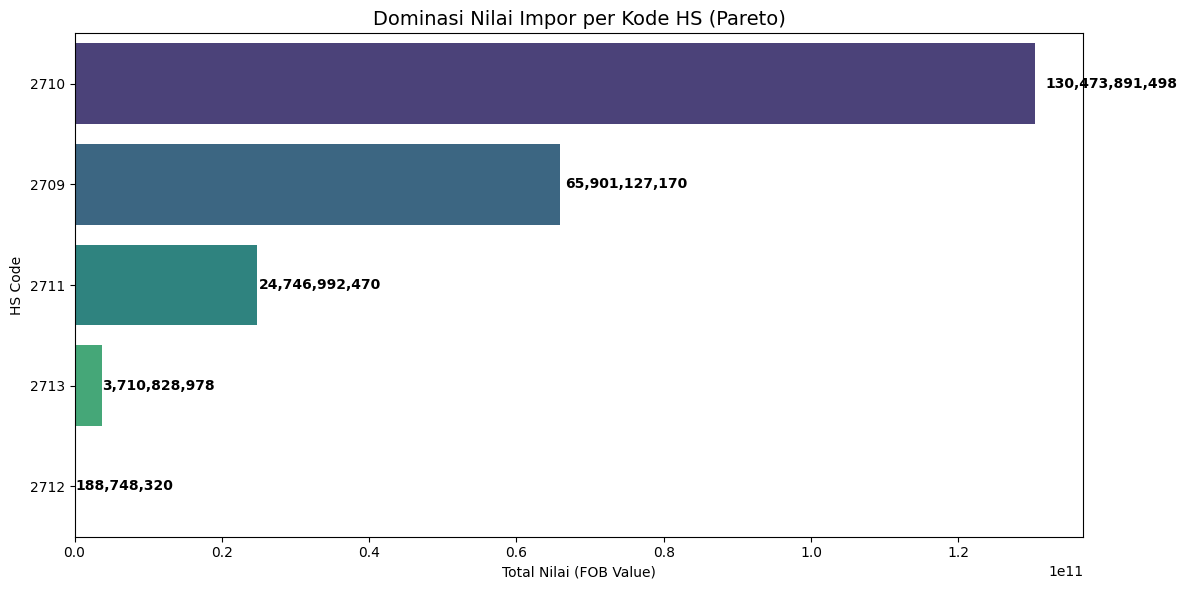

In [ ]:
# Agregasi data
pareto_data = df_combined_trade.groupby('hs_code')['fobvalue'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='fobvalue', y='hs_code', data=pareto_data, palette='viridis')

# Tambahkan label angka di ujung bar
for i, v in enumerate(pareto_data['fobvalue']):
    ax.text(v + (v*0.01), i, f'{v:,.0f}', va='center', fontweight='bold')

plt.title('Dominasi Nilai Impor per Kode HS (Pareto)', fontsize=14)
plt.xlabel('Total Nilai (FOB Value)')
plt.ylabel('HS Code')
plt.tight_layout()
plt.show()

# Pre Processing

## Checking Missing Value

In [ ]:
# Checking
print("Missing values:")
print(df_combined_trade[["refYear", "refMonth", "reporterDesc", "flowCode", "partnerDesc", "cmdCode", "cmdDesc", "netWgt", "fobvalue"]].isnull().sum())

Missing values:
refYear         0
refMonth        0
reporterDesc    0
flowCode        0
partnerDesc     0
cmdCode         0
cmdDesc         0
netWgt          0
fobvalue        0
dtype: int64


## Checking Duplicate Data

In [ ]:
print("Jumlah duplikat identik:", df_combined_trade.duplicated().sum())

Jumlah duplikat identik: 0


# Feature Enginnering

In [ ]:
# Agregasi bulanan per HS code

df_monthly = (
    df_combined_trade
    .groupby(['hs_code', 'refYear', 'refMonth'])
    .agg(
        monthly_fobvalue=('fobvalue', 'sum'),
        avg_fobvalue=('fobvalue', 'mean'),
        std_fobvalue=('fobvalue', 'std'),
        transaction_count=('fobvalue', 'count'),
        monthly_netWgt=('netWgt', 'sum'),
        avg_netWgt=('netWgt', 'mean')
    )
    .reset_index()
)

df_monthly['std_fobvalue'] = df_monthly['std_fobvalue'].fillna(0)

## Time Based Features

In [ ]:
df_monthly = (
    df_monthly
    .sort_values(['hs_code', 'refYear', 'refMonth'])
    .reset_index(drop=True)
)

df_monthly['value_per_kg'] = ( # fitur value per kg
    df_monthly['monthly_fobvalue'] /
    (df_monthly['monthly_netWgt'] + 1)
)

df_monthly['fobvalue_lag1'] = ( # lag fitur 1 bulan sebelumnya untuk nilai FOB
    df_monthly.groupby('hs_code')['monthly_fobvalue'].shift(1)
)

df_monthly['netWgt_lag1'] = ( # lag fitur 1 bulan sebelumnya untuk net weight
    df_monthly.groupby('hs_code')['monthly_netWgt'].shift(1)
)

df_monthly['fobvalue_lag3'] = ( # lag fitur 3 bulan sebelumnya untuk nilai FOB
    df_monthly.groupby('hs_code')['monthly_fobvalue'].shift(3)
)

df_monthly['fobvalue_roll3'] = ( # roll fitur 3 bulan sebelumnya untuk nilai FOB
    df_monthly.groupby('hs_code')['monthly_fobvalue']
    .rolling(3).mean()
    .reset_index(level=0, drop=True)
)

df_monthly['fobvalue_roll3_std'] = ( # fitur deviasi standar 3 bulan sebelumnya untuk FOB
    df_monthly.groupby('hs_code')['monthly_fobvalue']
    .rolling(3).std()
    .reset_index(level=0, drop=True)
)

df_monthly['mom_growth'] = ( # fitur persentase perubahan dibanding bulan sebelumnya
    df_monthly.groupby('hs_code')['monthly_fobvalue']
    .pct_change() * 100
)

df_monthly = df_monthly.dropna()

In [ ]:
# Statistik agregat per HS code

hs_stats = (
    df_monthly
    .groupby('hs_code')
    .agg(
        total_fobvalue=('monthly_fobvalue', 'sum'),
        avg_monthly_fobvalue=('monthly_fobvalue', 'mean'),
        volatility_overall=('monthly_fobvalue', 'std'),
        total_netWgt=('monthly_netWgt', 'sum'),
        avg_monthly_netWgt=('monthly_netWgt', 'mean'),
        avg_value_per_kg=('value_per_kg', 'mean'),
        total_transactions=('transaction_count', 'sum')
    )
    .reset_index()
)

yearly_sum = (
    df_monthly
    .groupby(['hs_code', 'refYear'])['monthly_fobvalue']
    .sum()
    .reset_index()
)

yoy_list = []

for hs, g in yearly_sum.groupby('hs_code'):
    g = g.sort_values('refYear')
    if len(g) >= 2 and g.iloc[0]['monthly_fobvalue'] > 0:
        n = len(g) - 1
        cagr = ((g.iloc[-1]['monthly_fobvalue'] /
                 g.iloc[0]['monthly_fobvalue']) ** (1 / n) - 1) * 100
    else:
        cagr = 0
    yoy_list.append({'hs_code': hs, 'yoy_cagr': cagr})

yoy_df = pd.DataFrame(yoy_list)

hs_stats = hs_stats.merge(yoy_df, on='hs_code', how='left')

total_all = hs_stats['total_fobvalue'].sum()
hs_stats['market_share_pct'] = (
    hs_stats['total_fobvalue'] / total_all * 100
)

In [ ]:
# Merge ke data bulanan

df_monthly = df_monthly.merge(
    hs_stats[['hs_code', 'total_fobvalue',
              'yoy_cagr', 'volatility_overall',
              'market_share_pct']],
    on='hs_code',
    how='left'
)

# Label Enginnering

In [ ]:
value_q33 = hs_stats['total_fobvalue'].quantile(0.33) # thresshold
value_q67 = hs_stats['total_fobvalue'].quantile(0.67)

growth_low = 10
growth_high = 20


def assign_dependency(row):
    value = row['total_fobvalue']
    growth = row['yoy_cagr']
    market_share = row['market_share_pct']

    if value > value_q67:
        return 'High'

    if market_share > 25:
        return 'High'

    if value < value_q33 and (growth < 0 or market_share < 1):
        return 'Low'

    return 'Medium'


df_monthly['dependency_level'] = (
    df_monthly
    .apply(assign_dependency, axis=1)
)

print("=== DEPENDENCY LEVEL DISTRIBUTION ===\n")

# Distribusi overall
print("Overall Distribution:")
print(df_monthly['dependency_level'].value_counts())
print(f"\nTotal rows: {len(df_monthly)}")
print()

# Summary per HS Code (dominant label)
print("Dominant Dependency Level per HS Code:")
for hs in df_monthly['hs_code'].unique():
    hs_data = df_monthly[df_monthly['hs_code'] == hs]
    dominant = hs_data['dependency_level'].mode()[0]
    count = hs_data['dependency_level'].value_counts()
    print(f"  {hs}: {dominant} ({count[dominant]}/{len(hs_data)} rows)")

=== DEPENDENCY LEVEL DISTRIBUTION ===

Overall Distribution:
dependency_level
High      66
Medium    66
Low       33
Name: count, dtype: int64

Total rows: 165

Dominant Dependency Level per HS Code:
  2709: High (33/33 rows)
  2710: High (33/33 rows)
  2711: Medium (33/33 rows)
  2712: Low (33/33 rows)
  2713: Medium (33/33 rows)


## Validation Label with K-means Clustering

In [ ]:
clustering_features = [
    'total_fobvalue',
    'yoy_cagr',
    'volatility_overall',
    'market_share_pct',
    'avg_monthly_fobvalue',
    'value_per_kg'
]

# Ambil data (gunakan agregasi per HS Code, bukan per bulan)
df_hs_agg = df_monthly.groupby('hs_code').agg({
    'total_fobvalue': 'first',  # ambil nilai pertama (sama semua karena dari merge)
    'yoy_cagr': 'first',
    'volatility_overall': 'first',
    'market_share_pct': 'first',
    'monthly_fobvalue': 'mean',  # rata-rata bulanan
    'value_per_kg': 'mean',
    'dependency_level': 'first'  # label
}).reset_index()

df_hs_agg.columns = ['hs_code', 'total_fobvalue', 'yoy_cagr', 'volatility_overall',
                     'market_share_pct', 'avg_monthly_fobvalue', 'value_per_kg', 'dependency_level']

# Standarisasi
X = df_hs_agg[clustering_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_hs_agg['cluster'] = kmeans.fit_predict(X_scaled)

# Mapping Cluster ke label
cluster_profile = (
df_hs_agg
.groupby('cluster')[clustering_features]
.mean()
)

cluster_ranking = cluster_profile.sort_values(
'total_fobvalue', ascending=False
)

cluster_map = {
cluster_ranking.index[0]: 'High',
cluster_ranking.index[1]: 'Medium',
cluster_ranking.index[2]: 'Low'
}

df_hs_agg['cluster_label'] = df_hs_agg['cluster'].map(cluster_map)

print("=== PERBANDINGAN LABEL ===\n")

comparison = df_hs_agg[
['hs_code', 'dependency_level', 'cluster_label']
]

print(comparison)
print()

agreement = (
comparison['dependency_level'] ==
comparison['cluster_label']
).sum()

total = len(comparison)
agreement_pct = agreement / total * 100

print(f"Agreement: {agreement}/{total} ({agreement_pct:.1f}%)\n")

ari = adjusted_rand_score(
df_hs_agg['dependency_level'],
df_hs_agg['cluster']
)

nmi = normalized_mutual_info_score(
df_hs_agg['dependency_level'],
df_hs_agg['cluster']
)

print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}\n")

print("=== CONFUSION MATRIX ===\n")

confusion = pd.crosstab(
df_hs_agg['dependency_level'],
df_hs_agg['cluster_label'],
rownames=['Rule-based'],
colnames=['Clustering']
)

print(confusion)

=== PERBANDINGAN LABEL ===

  hs_code dependency_level cluster_label
0    2709             High          High
1    2710             High          High
2    2711           Medium        Medium
3    2712              Low        Medium
4    2713           Medium           Low

Agreement: 3/5 (60.0%)

Adjusted Rand Index: 0.375
Normalized Mutual Information: 0.737

=== CONFUSION MATRIX ===

Clustering  High  Low  Medium
Rule-based                   
High           2    0       0
Low            0    0       1
Medium         0    1       1


## Drop Unused Feature

In [ ]:
feature_cols = [
    'monthly_fobvalue',
    'monthly_netWgt',
    'value_per_kg',
    'fobvalue_lag1',
    'fobvalue_lag3',
    'fobvalue_roll3',
    'fobvalue_roll3_std',
    'mom_growth',
]

df_ml = df_monthly[feature_cols + ['dependency_level', 'hs_code']].dropna()

df_ml = df_ml.dropna()

In [ ]:
df_ml.head(100)

,monthly_fobvalue,monthly_netWgt,value_per_kg,fobvalue_lag1,fobvalue_lag3,fobvalue_roll3,fobvalue_roll3_std,mom_growth,dependency_level,hs_code
0,1502615208,0,1.502615e+09,1.458954e+09,8.029212e+08,1.631845e+09,2.625541e+08,2.992635,High,2709
1,1056130234,0,1.056130e+09,1.502615e+09,1.933967e+09,1.339233e+09,2.461443e+08,-29.713860,High,2709
2,1684340268,0,1.684340e+09,1.056130e+09,1.458954e+09,1.414362e+09,3.232699e+08,59.482251,High,2709
3,1315433450,0,1.315433e+09,1.684340e+09,1.502615e+09,1.351968e+09,3.156945e+08,-21.902155,High,2709
4,1628331976,0,1.628332e+09,1.315433e+09,1.056130e+09,1.542702e+09,1.988025e+08,23.786724,High,2709
...,...,...,...,...,...,...,...,...,...,...
95,737457548,0,7.374575e+08,6.697456e+08,8.038426e+08,6.987361e+08,3.488904e+07,10.110101,Medium,2711
96,710002940,0,7.100029e+08,7.374575e+08,6.890053e+08,7.057354e+08,3.405711e+07,-3.722873,Medium,2711
97,664171950,0,6.641720e+08,7.100029e+08,6.697456e+08,7.038775e+08,3.702480e+07,-6.455042,Medium,2711
98,559261382,3,1.398153e+08,6.641720e+08,7.374575e+08,6.444788e+08,7.727626e+07,-15.795694,Medium,2711


## Encoding

In [ ]:
label_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df_ml['dependency_level'] = df_ml['dependency_level'].map(label_mapping)

le = LabelEncoder()
df_ml['hs_code_enc'] = le.fit_transform(df_ml['hs_code'])

df_ml = df_ml.drop(columns=['hs_code'])

In [ ]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   monthly_fobvalue    165 non-null    int64  
 1   monthly_netWgt      165 non-null    int64  
 2   value_per_kg        165 non-null    float64
 3   fobvalue_lag1       165 non-null    float64
 4   fobvalue_lag3       165 non-null    float64
 5   fobvalue_roll3      165 non-null    float64
 6   fobvalue_roll3_std  165 non-null    float64
 7   mom_growth          165 non-null    float64
 8   dependency_level    165 non-null    int64  
 9   hs_code_enc         165 non-null    int64  
dtypes: float64(6), int64(4)
memory usage: 13.0 KB


In [ ]:
# Cek korelasi antara fitur dan target
correlation = df_ml.corr()['dependency_level'].sort_values(ascending=False)
print(correlation)

dependency_level      1.000000
fobvalue_roll3        0.823686
monthly_fobvalue      0.807432
fobvalue_lag1         0.807160
fobvalue_lag3         0.803966
value_per_kg          0.797526
fobvalue_roll3_std    0.774846
monthly_netWgt        0.080250
mom_growth            0.008647
hs_code_enc          -0.755929
Name: dependency_level, dtype: float64


# Split Data

In [ ]:
X = df_ml[feature_cols]
y = df_ml['dependency_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X.head()

,monthly_fobvalue,monthly_netWgt,value_per_kg,fobvalue_lag1,fobvalue_lag3,fobvalue_roll3,fobvalue_roll3_std,mom_growth
0,1502615208,0,1.502615e+09,1.458954e+09,8.029212e+08,1.631845e+09,2.625541e+08,2.992635
1,1056130234,0,1.056130e+09,1.502615e+09,1.933967e+09,1.339233e+09,2.461443e+08,-29.713860
2,1684340268,0,1.684340e+09,1.056130e+09,1.458954e+09,1.414362e+09,3.232699e+08,59.482251
3,1315433450,0,1.315433e+09,1.684340e+09,1.502615e+09,1.351968e+09,3.156945e+08,-21.902155
4,1628331976,0,1.628332e+09,1.315433e+09,1.056130e+09,1.542702e+09,1.988025e+08,23.786724


# Modelling

## XGBoost

## SMOTE Traininng Set

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Sebelum SMOTE:", y_train.value_counts())
print("Sesudah SMOTE:", y_train_res.value_counts())

Sebelum SMOTE: dependency_level
2    53
1    53
0    26
Name: count, dtype: int64
Sesudah SMOTE: dependency_level
2    53
0    53
1    53
Name: count, dtype: int64


In [ ]:
model_xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)

# training
model_xgb.fit(X_train_res, y_train_res)

# prediksi
y_pred_xgb = model_xgb.predict(X_test)

## Testing

In [ ]:
# 1. Cek dulu distribusi tahun yang tersedia
print("Tahun yang tersedia di data:", df_monthly['refYear'].unique())

# 2. Pastikan mapping benar
label_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df_monthly['dependency_level_num'] = df_monthly['dependency_level'].map(label_mapping)

# 3. Split Data (Gunakan tahun terakhir yang ada di data kamu sebagai Test)
tahun_maks = df_monthly['refYear'].max()
train = df_monthly[df_monthly['refYear'] < tahun_maks]
test = df_monthly[df_monthly['refYear'] == tahun_maks]

print(f"Jumlah data Train: {len(train)}")
print(f"Jumlah data Test (Tahun {tahun_maks}): {len(test)}")

# 4. Jika data test ada, lanjutkan
if len(test) > 0:
    X_train, y_train = train[feature_cols], train['dependency_level_num']
    X_test, y_test = test[feature_cols], test['dependency_level_num']

    # Latih model
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)

    # Ambil label unik yang benar-benar ada di y_test agar tidak error lagi
    unique_labels = sorted(y_test.unique())
    target_names_adjusted = [name for val, name in sorted(zip(label_mapping.values(), label_mapping.keys())) if val in unique_labels]

    print("\n=== Hasil Time-Series Validation ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=target_names_adjusted))
else:
    print("Error: Data Test kosong! Cek filter tahun atau kolom refYear kamu.")

Tahun yang tersedia di data: [ 2  3  4  5  6  7  8  9 10 11 12]
Jumlah data Train: 150
Jumlah data Test (Tahun 12): 15

=== Hasil Time-Series Validation ===
Accuracy: 0.9333
              precision    recall  f1-score   support

         Low       0.90      1.00      0.95         9
      Medium       1.00      0.67      0.80         3
        High       1.00      1.00      1.00         3

    accuracy                           0.93        15
   macro avg       0.97      0.89      0.92        15
weighted avg       0.94      0.93      0.93        15



In [ ]:
from imblearn.over_sampling import SMOTENC

cat_features_index = [X.columns.get_loc('hs_code')]
smote_nc = SMOTENC(categorical_features=cat_features_index, random_state=42)
X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)

print(f"Jumlah data setelah SMOTE: {len(y_train_res)}")
print(y_train_res.value_counts())

ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 1, n_samples = 1

In [ ]:
model_xgb_improved = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=300, # Saya naikkan sedikit dari 100 agar belajar lebih lama
    subsample=0.8,
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    enable_categorical=True,
    eval_metric='mlogloss'
)

model_xgb_improved.fit(X_train_res, y_train_res)

y_pred_improved = model_xgb_improved.predict(X_test)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:hs_code: object

In [ ]:
from sklearn.model_selection import GridSearchCV

# 1. Definisikan Parameter Grid
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.8, 0.9]
}

# 2. Inisialisasi Model Dasar
# Pastikan enable_categorical=True karena kamu punya hs_code
model_xgb_base = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    enable_categorical=True,
    eval_metric='mlogloss'
)

# 3. Jalankan Grid Search menggunakan data hasil SMOTE (X_train_res, y_train_res)
grid_search = GridSearchCV(
    estimator=model_xgb_base,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1 # Menampilkan progress agar kamu tahu proses sedang jalan
)

# Fitting menggunakan data hasil resampling
grid_search.fit(X_train_res, y_train_res)

# 4. Ambil Parameter dan Model Terbaik
print("Best Parameters found:", grid_search.best_params_)
model_xgb_final = grid_search.best_estimator_

# 5. Prediksi pada data TEST asli (bukan data SMOTE)
y_pred_final = model_xgb_final.predict(X_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}


In [ ]:
model_xgb_improved = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100, # Saya naikkan sedikit dari 100 agar belajar lebih lama
    subsample=0.9,
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    enable_categorical=True,
    eval_metric='mlogloss'
)

model_xgb_improved.fit(X_train_res, y_train_res)

y_pred_improved = model_xgb_improved.predict(X_test)

NameError: name 'X_train_res' is not defined

In [ ]:
print("="*30)
print(" EVALUASI MODEL SETELAH IMPROVEMENT ")
print("="*30)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_improved):.4f}")
print("\nClassification Report:")
target_names = ['Low', 'Medium', 'High']
print(classification_report(y_test, y_pred_improved, target_names=target_names))

 EVALUASI MODEL SETELAH IMPROVEMENT 
XGBoost Accuracy: 0.4815

Classification Report:
              precision    recall  f1-score   support

         Low       0.50      0.42      0.46       226
      Medium       0.36      0.52      0.43       185
        High       0.65      0.50      0.57       210

    accuracy                           0.48       621
   macro avg       0.51      0.48      0.49       621
weighted avg       0.51      0.48      0.49       621



In [ ]:
# Pastikan tipe data kategori sudah benar
X_train_res['hs_code'] = X_train_res['hs_code'].astype('category')
X_test['hs_code'] = X_test['hs_code'].astype('category')

# Buat objek Dataset LightGBM (opsional, tapi disarankan untuk efisiensi)
train_data = lgb.Dataset(X_train_res, label=y_train_res, categorical_feature=['hs_code'])

In [ ]:
model_lgbm = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=31,         # Parameter kunci LightGBM
    max_depth=-3,          # Biarkan leaf-wise yang bekerja
    min_child_samples=20,  # Menghindari overfitting
    random_state=42,
    class_weight='balanced', # Menangani sisa-sisa ketidakseimbangan
    importance_type='gain'   # Agar Feature Importance lebih akurat secara ekonomi
)

model_lgbm.fit(X_train_res, y_train_res)

In [ ]:
y_pred_lgbm = model_lgbm.predict(X_test)

print(f"LightGBM Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print("\nClassification Report LightGBM:")
print(classification_report(y_test, y_pred_lgbm, target_names=['Low', 'Medium', 'High']))

# Evaluation

In [ ]:
target_names = ['Low', 'Medium', 'High']  # Sesuaikan dengan urutan label
print(f"\n=== XGBoost Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=target_names))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


=== XGBoost Results ===
Accuracy: 0.9394

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         7
      Medium       0.87      1.00      0.93        13
        High       1.00      0.85      0.92        13

    accuracy                           0.94        33
   macro avg       0.96      0.95      0.95        33
weighted avg       0.95      0.94      0.94        33


Confusion Matrix:
[[ 7  0  0]
 [ 0 13  0]
 [ 0  2 11]]


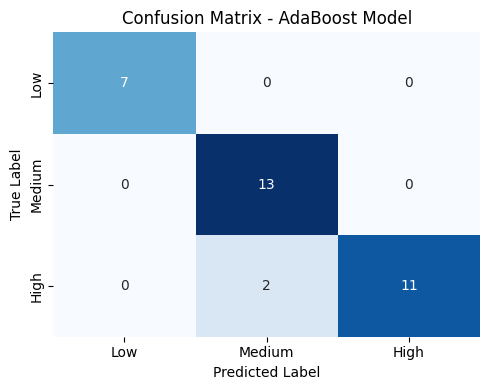

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Visualisasi
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - AdaBoost Model')
plt.tight_layout()
plt.show()

/tmp/ipython-input-114307663.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


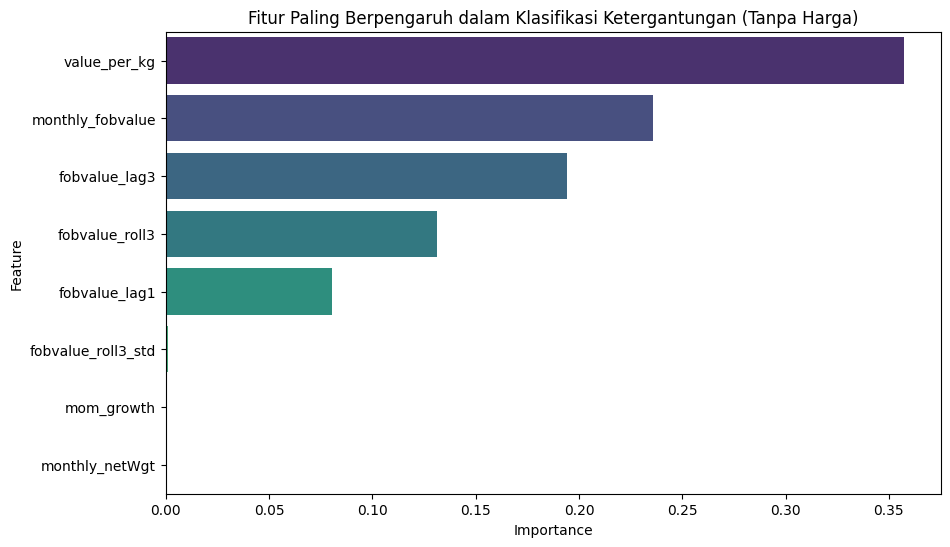

In [ ]:
importances = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Fitur Paling Berpengaruh dalam Klasifikasi Ketergantungan (Tanpa Harga)')
plt.show()

# Save Model

In [ ]:
with open('xgb_model_Smote.pkl', 'wb') as f:
    pickle.dump(model_xgb, f)

print("Model 'model_xgb_Smote' saved as 'xgb_model_Smote.pkl'")

Model 'model_xgb_Smote' saved as 'xgb_model_Smote.pkl'
